In [1]:
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency
from scipy import stats
from matplotlib import pyplot as plt
from sklearn import metrics as m
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 

randomseed=7

Using TensorFlow backend.


In [2]:
data= pd.read_csv('../sep19SexAndAgeAddedFINAL DATASET_ver2.txt',sep=',')

In [3]:
# filter the data set 
data=data[data.FIELD_16!=1] # exclude people who are diagnosed for (diabetes) 
data=data[data.FIELD_23!=1] # exclude people who are on medication for diabetes

data=data[data.FIELD_15!=1] # exclude people who are diagnosed for (high blood pressure)
data=data[data.FIELD_22!=1] # exclude people who are on medication for high blood pressure

data=data[data.FIELD_17!=1] # exclude people who are diagnosed for hyperlipidemia
data=data[data.FIELD_24!=1] # exclude people who are on medication for hyperlipidemia

In [4]:
# add Class to the dataset 
conditions = [
    (data.L100800 < 100)  ,
    (data.L100800 >= 100) & (data.L100800 < 126),
    (data.L100800 >= 126)]
choices = [0,1,2]
data['CLASS'] = np.select(conditions, choices, default=0) 

In [5]:
mydata=data.copy()[['L104600','L103000','S000300','L101700','L100700','FIELD_33','FIELD_38','FIELD_40','S000501', 'S000502',
                    'FIELD_31','SEX','AGE','CLASS']].dropna()
mydata.shape

(142716, 14)

In [6]:
x=mydata[['L104600','L103000','S000300','L101700','L100700','FIELD_33','FIELD_38','FIELD_40','S000501', 'S000502',
                    'FIELD_31','SEX','AGE']]
y=mydata[['CLASS']]


sm = SMOTE(random_state=randomseed)
X_res, y_res = sm.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))
print(y_res[y_res==0].shape[0], y_res[y_res==1].shape[0], y_res[y_res==2].shape[0])

print(X_res.shape,y_res.shape)



Resampled dataset shape Counter({1: 104030, 0: 104030, 2: 104030})
104030 104030 104030
(312090, 13) (312090,)


In [7]:
y_res2=y_res.copy()
# from keras.utils import to_categorical
# y_res2 = to_categorical(y_res)  

xtrain,xtest,ytrain,ytest=train_test_split(X_res,y_res2,random_state=randomseed, test_size=0.2)

In [8]:
from sklearn.kernel_approximation import RBFSampler
rbf_feature = RBFSampler(gamma=.01, random_state=randomseed,n_components=X_res.shape[1])
X_res = rbf_feature.fit_transform(X_res)


xtrain,xtest,ytrain,ytest=train_test_split(X_res,y_res2,random_state=randomseed, test_size=0.2)

In [9]:
# from sklearn.kernel_approximation import RBFSampler
# from sklearn.linear_model import SGDClassifier
# X = [[0, 0], [1, 1], [1, 0], [0, 1]]
# y = [0, 0, 1, 1]
# rbf_feature = RBFSampler(gamma=1, random_state=1,n_components=2)
# X_features = rbf_feature.fit_transform(X)

# X_features

In [10]:
diabetic = mydata[mydata.CLASS==2]
prediabetic = mydata[mydata.CLASS==1]
normal = mydata[mydata.CLASS==0]

print(diabetic.shape[0],prediabetic.shape[0],normal.shape[0])

2451 36235 104030


In [11]:
diabetic_test = diabetic.sample(500,random_state=randomseed)
prediabetic_test = prediabetic.sample(500,random_state=randomseed)
normal_test = normal.sample(500,random_state=randomseed)
test=pd.concat([diabetic_test,prediabetic_test,normal_test])

diabetic_train = diabetic.drop(diabetic_test.index)
prediabetic_train = prediabetic.drop(prediabetic_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
normal_train = normal.drop(normal_test.index).sample(diabetic_train.shape[0],random_state=randomseed)
train=pd.concat([diabetic_train,prediabetic_train,normal_train])

In [12]:
# xtrain=train.iloc[:,:-1]
# ytrain=train.iloc[:,-1]
# xtest=test.iloc[:,:-1]
# ytest=test.iloc[:,-1]

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(random_state=randomseed,n_estimators=100,max_depth=10 ) 
rf.fit(xtrain,ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=7, verbose=0,
                       warm_start=False)

In [14]:
ypred= rf.predict(xtest)

0.49588259796853473
              precision    recall  f1-score   support

           0       0.45      0.45      0.45     20709
           1       0.47      0.40      0.43     20827
           2       0.55      0.63      0.59     20882

    accuracy                           0.50     62418
   macro avg       0.49      0.50      0.49     62418
weighted avg       0.49      0.50      0.49     62418



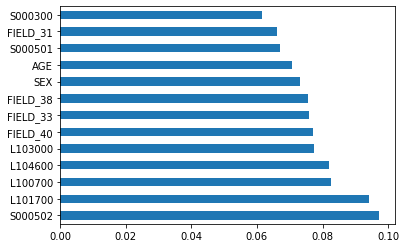

Index(['S000502', 'L101700', 'L100700', 'L104600', 'L103000', 'FIELD_40',
       'FIELD_33', 'FIELD_38', 'SEX', 'AGE', 'S000501', 'FIELD_31', 'S000300'],
      dtype='object')
Accuracy on training set: 0.599
Accuracy on test set: 0.496


,0,1,2
0,9381,6088,5240
1,6966,8366,5495
2,4483,3194,13205


In [15]:
score=rf.score(xtest,ytest)
print(score)

print(classification_report(ytest,ypred))

feat_importances = pd.Series(rf.feature_importances_, index=test.iloc[:,:-1].columns)
feat_importances.nlargest(16).plot(kind='barh')
plt.show()

print(feat_importances.nlargest(16).index)

print("Accuracy on training set: {:.3f}".format(rf.score(xtrain,ytrain)))
print("Accuracy on test set: {:.3f}".format(rf.score(xtest,ytest ))) 


confmatrx=pd.DataFrame(confusion_matrix(ytest,ypred))
confmatrx.head()



In [ ]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

In [ ]:
# model= Sequential()
# model.add(Dense(input_dim=13,units=128,activation='relu', kernel_initializer='uniform'))
# model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
# model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
# model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
# model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  
# model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
# model.add(Dense(units=3, kernel_initializer='uniform', activation='softmax'))

model= Sequential()
model.add(Dense(input_dim=13,units=512,activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25)) 
model.add(Dense(units=4, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=3, kernel_initializer='uniform', activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])

In [ ]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=20000)

In [ ]:
history=h
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()